## Coursera Capstone Project: Bay Area Neighborhood Comparisons

## Data loading and preparation
#### Load libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

Read the file that contains name, zip codes and area for all zip codes of the bay area and drop irelevant columns.

In [2]:
BayAreaZip = pd.read_csv('bayarea_zipcodes.csv')
BayAreaZip.drop(columns=['the_geom', 'PO_NAME', 'Length__', 'Area__'], axis=1, inplace=True)
BayAreaZip['ZIP'] = BayAreaZip['ZIP'].astype(int).astype(str)
print('\nTotal number of zip codes in the bay area: {}'.format(BayAreaZip.shape[0]))


Total number of zip codes in the bay area: 187


#### Define a function to extract rows based on Bay Area's zip codes.

In [3]:
def extractBayAreaRows(df):
    #extract those rows corresponding to bay areas only based on bay area's zip codes. 
    #the dataframe df need to have a column named 'ZIP' for zip codes with datatye int
    bayAreaRows = df['ZIP'].isin(list(BayAreaZip['ZIP']))
    df = df[bayAreaRows]
    df = df.reset_index(drop=True)
    df.dropna(inplace=True)
    return(df)

#### Read the file for population of every zip code of California 2019 and match to only Bay Area zip codes.

In [4]:
#Read the population per zip code file and drop irrelevant columns
PopByZip = pd.read_excel('CA population by zip code.xlsx')
#pd.set_option('display.max_rows', None)  #display all rows of DF
PopByZip = PopByZip.drop(columns=['Rank'])
PopByZip = PopByZip.rename(columns={'Zip Code': 'ZIP'})
#print(PopByZip.head())

#Some rows have multiple zip codes for ties. need to split to one row per zip code
singleZip = PopByZip[~(PopByZip['ZIP'].str.contains('and').fillna(False))]  #rows with single zip
multiZip = PopByZip[PopByZip['ZIP'].str.contains('and').fillna(False)] #rows with multi zip tie
 

#Split rows with multiple zip
zipSplitList = []
popSplitList = []

for row in multiZip.itertuples():
    z = row.ZIP.split()
    zipSplitList = zipSplitList + z
    pop = row.Population
    #print(len(zip))
    for i in range(len(z)):  #populate popSplitList for same # of rows as splitted zip code rows
        popSplitList.append(pop)

multiZipSplitted = pd.DataFrame([zipSplitList, popSplitList]).T
multiZipSplitted.columns=['ZIP', 'Population']
multiZipSplitted['ZIP'] = (pd.to_numeric(multiZipSplitted['ZIP'], errors='coerce')) 
multiZipSplitted.dropna(inplace=True)
multiZipSplitted['ZIP'] = multiZipSplitted['ZIP'].astype(int).astype(str)
multiZipSplitted.reset_index(drop=True, inplace=True)
singleZip['ZIP'] = singleZip['ZIP'].astype(int).astype(str)

PopByZipNew = pd.concat([singleZip, multiZipSplitted], sort=True)  #reconstruct the DF with unique one zip per row
 

#Extract Bay Area rows
bayAreaRows = PopByZipNew['ZIP'].isin(list(BayAreaZip['ZIP']))
 
PopByZipNew = PopByZipNew[bayAreaRows]
PopByZipNew = PopByZipNew.reset_index(drop=True)
PopByZipNew.dropna(inplace=True)
 

#pd.reset_option('display.max_rows', None)  #display all rows
BayAreaZip = BayAreaZip.merge(PopByZipNew, left_on='ZIP', right_on='ZIP', how='inner')
#BayAreaZip['Population density'] = BayAreaZip['Population'] / BayAreaZip['Area__']
print('\nTotal {} Bay Area zip code\'s population for each zip code added.'.format(PopByZipNew.shape[0]))
BayAreaZip.head()




Total 186 Bay Area zip code's population for each zip code added.


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,ZIP,STATE,Population
0,95620,CA,21854
1,95476,CA,36792
2,95140,CA,115
3,95134,CA,27224
4,95035,CA,77562


#### Read the file for latitude and longitude of every zip code of California and match to only Bay Area zip codes.

In [5]:
#Read and clean the Lat, Lng file
latLng  = pd.read_excel('CA-zip-code-latitude-and-longitude.xlsx')
latLng.drop(columns=['State', 'Timezone', 'Daylight savings time flag', 'geopoint'], inplace=True)
bayAreaRows = latLng['Zip'].isin(list(BayAreaZip['ZIP']))
latLng = latLng[bayAreaRows]
latLng['Zip'] = latLng['Zip'].astype(int).astype(str)
latLng.reset_index(drop=True, inplace=True)

#merge Lat, Lng into master DF  
BayAreaZip = BayAreaZip.merge(latLng, left_on='ZIP', right_on='Zip', how='inner')
BayAreaZip.drop(columns=['Zip'], inplace=True)
print('\n Latitude and longitudes added for {} bay area zip codes.'.format(len(BayAreaZip)))
BayAreaZip.head()


 Latitude and longitudes added for 186 bay area zip codes.


,ZIP,STATE,Population,City,Latitude,Longitude
0,95620,CA,21854,Dixon,38.427208,-121.81348
1,95476,CA,36792,Sonoma,38.277147,-122.47058
2,95140,CA,115,Mount Hamilton,37.388718,-121.63845
3,95134,CA,27224,San Jose,37.412539,-121.94461
4,95035,CA,77562,Milpitas,37.436451,-121.89438


#### Add median home values (Mar 2020) to each zip code:

In [6]:
#This file has nationwide by-zip-code monthly home value data from January 1996 to March 2020
#Only keep March 2020 data
housingPrice = pd.read_csv('Zip_Zhvi_AllHomes.csv')
housingPrice = housingPrice[['RegionName', 'Metro', 'CountyName', '3/31/2020']]
housingPrice.rename(columns={'RegionName': 'ZIP', '3/31/2020': 'House Price 2020 (k)'}, inplace=True)
housingPrice['House Price 2020 (k)'] = housingPrice['House Price 2020 (k)'] /1000.0
housingPrice = housingPrice.reset_index(drop=True)
#print(housingPrice.head())

#Extract Bay Area rows
bayAreaRows = housingPrice['ZIP'].isin(list(BayAreaZip['ZIP']))
PopByZipNew = PopByZipNew[bayAreaRows]
PopByZipNew = PopByZipNew.reset_index(drop=True)
PopByZipNew.dropna(inplace=True)

#Merge March 2020 housing price data to master DF
housingPrice['ZIP'] = housingPrice['ZIP'].astype(int).astype(str)
BayAreaZip = BayAreaZip.merge(housingPrice, left_on='ZIP', right_on='ZIP', how='inner')
#BayAreaZip.drop(columns=['ZIP'], inplace=True)
print('\n Housing price added for {} zip codes.'.format(len(BayAreaZip)))
BayAreaZip.head()



 Housing price added for 180 zip codes.


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


,ZIP,STATE,Population,City,Latitude,Longitude,Metro,CountyName,House Price 2020 (k)
0,95620,CA,21854,Dixon,38.427208,-121.81348,Vallejo-Fairfield,Solano County,454.289
1,95476,CA,36792,Sonoma,38.277147,-122.47058,Santa Rosa,Sonoma County,823.215
2,95140,CA,115,Mount Hamilton,37.388718,-121.63845,San Jose-Sunnyvale-Santa Clara,Santa Clara County,1517.858
3,95134,CA,27224,San Jose,37.412539,-121.94461,San Jose-Sunnyvale-Santa Clara,Santa Clara County,1015.461
4,95035,CA,77562,Milpitas,37.436451,-121.89438,San Jose-Sunnyvale-Santa Clara,Santa Clara County,1104.234



#### Read California 2017 income data per zip code from IRS data file, and add to the master dataframe.

In [7]:
income = pd.read_excel('17zp05ca.xlsx', header=None, skiprows=6, usecols = [0, 18])  #only read this two columns
income = income[:-18]  #drop 18 bottom rows texts
income.columns = ['ZIP', 'Total AGI (k)']  #first column is ZIP, second is AGI of the zip code. Within each ZIP, first row is total AGI of the zip code. 
#Other rows are breakdown by income buckets. Will only use the first row to calculate per capita income for the zip code.
income = income.dropna()
income = income.groupby('ZIP').first()  #total AGI for each zip of California
income = income.reset_index()

#Merge income data to master DF
income['ZIP'] = income['ZIP'].astype(int).astype(str)
BayAreaZip = BayAreaZip.merge(income, left_on='ZIP', right_on='ZIP', how='inner')
print('Income added for {} zip codes.'.format(len(BayAreaZip)))
BayAreaZip ['AGI per capita (k)'] = BayAreaZip ['Total AGI (k)'] / BayAreaZip ['Population']
BayAreaZip[['Population', 'House Price 2020 (k)','Total AGI (k)', 'AGI per capita (k)']] = BayAreaZip[['Population','House Price 2020 (k)','Total AGI (k)', 'AGI per capita (k)']].astype(int)

#pd.options.display.float_format = '${:,.3f}'.format
BayAreaZip.head()


Income added for 171 zip codes.


,ZIP,STATE,Population,City,Latitude,Longitude,Metro,CountyName,House Price 2020 (k),Total AGI (k),AGI per capita (k)
0,95620,CA,21854,Dixon,38.427208,-121.81348,Vallejo-Fairfield,Solano County,454,705675,32
1,95476,CA,36792,Sonoma,38.277147,-122.47058,Santa Rosa,Sonoma County,823,1834068,49
2,95140,CA,115,Mount Hamilton,37.388718,-121.63845,San Jose-Sunnyvale-Santa Clara,Santa Clara County,1517,26968,234
3,95134,CA,27224,San Jose,37.412539,-121.94461,San Jose-Sunnyvale-Santa Clara,Santa Clara County,1015,1889468,69
4,95035,CA,77562,Milpitas,37.436451,-121.89438,San Jose-Sunnyvale-Santa Clara,Santa Clara County,1104,3892073,50


## Choropleth map of the bay area
#### Convert California by zip GeoJson file to bay area only.

In [8]:
"""
Only for choropleth maps purpose, Need the polygon coordinates data for each zip code. 
It Was avaliable in the dataset, but for this project's purpose it was dropped from the dataframe.
"""

"""
CAJson = r'ca_california_zip_codes_geo.min.json'   #California by zip code GeoJson file
CAJsonDF = pd.read_json (CAJson)
#the GeoJson file has two columns: 'type', 'features'
bayAreaZipList = []
for row in CAJsonDF.itertuples():
    a = row.features['properties']['ZCTA5CE10'] in list(BayAreaZip['ZIP'])
    bayAreaZipList.append(a)
bayAreaZipList
bayAreaJsonDF = CAJsonDF[bayAreaZipList]
bayAreaJsonDF.head()

#a function to write pandas DataFrame as GeoJson file, code from the link below:
#https://geoffboeing.com/2015/10/exporting-python-data-geojson/
def df_to_geojson(df, properties, lat='latitude', lon='longitude'):
    geojson = {'type':'FeatureCollection', 'features':[]}
    for _, row in df.iterrows():
        feature = {'type':'Feature',
                   'properties':{},
                   'geometry':{'type':'Point',
                               'coordinates':[]}}
        feature['geometry']['coordinates'] = [row[lon],row[lat]]
        for prop in properties:
            feature['properties'][prop] = row[prop]
        geojson['features'].append(feature)
    return geojson

bayAreaJson = bayAreaJsonDF.to_json('bayAreaByZipGeoJson.json', orient='columns')
"""

"\nCAJson = r'ca_california_zip_codes_geo.min.json'   #California by zip code GeoJson file\nCAJsonDF = pd.read_json (CAJson)\n#the GeoJson file has two columns: 'type', 'features'\nbayAreaZipList = []\nfor row in CAJsonDF.itertuples():\n    a = row.features['properties']['ZCTA5CE10'] in list(BayAreaZip['ZIP'])\n    bayAreaZipList.append(a)\nbayAreaZipList\nbayAreaJsonDF = CAJsonDF[bayAreaZipList]\nbayAreaJsonDF.head()\n\n#a function to write pandas DataFrame as GeoJson file, code from the link below:\n#https://geoffboeing.com/2015/10/exporting-python-data-geojson/\ndef df_to_geojson(df, properties, lat='latitude', lon='longitude'):\n    geojson = {'type':'FeatureCollection', 'features':[]}\n    for _, row in df.iterrows():\n        feature = {'type':'Feature',\n                   'properties':{},\n                   'geometry':{'type':'Point',\n                               'coordinates':[]}}\n        feature['geometry']['coordinates'] = [row[lon],row[lat]]\n        for prop in proper

#### Display population by zip by choropleth map. 

In [9]:
"""
Only for choropleth maps purpose, Need the polygon coordinates data for each zip code. 
It Was avaliable in the dataset, but for this project's purpose it was dropped from the dataframe.
"""

"""
import folium
import matplotlib.pyplot as plt
#bayAreaJson = r'bayAreaByZipGeoJson.json'
bayAreaJson = r'ca_california_zip_codes_geo.min.json'

bayAreaLat = 37.8272   #bay area lat, lng
bayAreaLng = -122.2913
bayAreaMap = folium.Map(location=[bayAreaLat, bayAreaLng], zoom_start=8) #tiles='Mapbox Bright'
threshold_scale = np.linspace(BayAreaZip['Population'].min(),BayAreaZip['Population'].max(),6,dtype=int)
threshold_scale = threshold_scale.tolist()
threshold_scale[-1] = threshold_scale[-1] + 1
bayAreaMap.choropleth(geo_data=bayAreaJson,
                     data=BayAreaZip,
                     columns=['ZIP', 'Population'],
                     key_on='feature.properties.ZCTA5CE10',
                     fill_color='YlOrRd',
                     fill_opacity=0.7,
                     line_opacity=0.2,
                     legend_name='Population',
                     threshold_scale=threshold_scale
                     )
bayAreaMap
"""

"\nimport folium\nimport matplotlib.pyplot as plt\n#bayAreaJson = r'bayAreaByZipGeoJson.json'\nbayAreaJson = r'ca_california_zip_codes_geo.min.json'\n\nbayAreaLat = 37.8272   #bay area lat, lng\nbayAreaLng = -122.2913\nbayAreaMap = folium.Map(location=[bayAreaLat, bayAreaLng], zoom_start=8) #tiles='Mapbox Bright'\nthreshold_scale = np.linspace(BayAreaZip['Population'].min(),BayAreaZip['Population'].max(),6,dtype=int)\nthreshold_scale = threshold_scale.tolist()\nthreshold_scale[-1] = threshold_scale[-1] + 1\nbayAreaMap.choropleth(geo_data=bayAreaJson,\n                     data=BayAreaZip,\n                     columns=['ZIP', 'Population'],\n                     key_on='feature.properties.ZCTA5CE10',\n                     fill_color='YlOrRd',\n                     fill_opacity=0.7,\n                     line_opacity=0.2,\n                     legend_name='Population',\n                     threshold_scale=threshold_scale\n                     )\nbayAreaMap\n"

 #### Display housing price by zip by choropleth map.

In [10]:
"""
Only for choropleth maps purpose, Need the polygon coordinates data for each zip code. 
It Was avaliable in the dataset, but for this project's purpose it was dropped from the dataframe.
"""

"""
import folium
import matplotlib.pyplot as plt
#bayAreaJson = r'bayAreaByZipGeoJson.json'
bayAreaJson = r'ca_california_zip_codes_geo.min.json'
 
bayAreaLat = 37.8272   #bay area lat, lng
bayAreaLng = -122.2913
bayAreaMap = folium.Map(location=[bayAreaLat, bayAreaLng], zoom_start=8) #tiles='Mapbox Bright'
threshold_scale = np.linspace(BayAreaZip['House Price 2020 (k)'].min(),BayAreaZip['House Price 2020 (k)'].max(),6,dtype=int)

threshold_scale = threshold_scale.tolist()
threshold_scale[-1] = threshold_scale[-1] + 1
bayAreaMap.choropleth(geo_data=bayAreaJson,
                     data=BayAreaZip,
                     columns=['ZIP', 'House Price 2020 (k)'],
                     key_on='feature.properties.ZCTA5CE10',
                     fill_color='YlOrRd',
                     fill_opacity=0.7,
                     line_opacity=0.2,
                     legend_name='House Price 2020 (k)',
                     threshold_scale=threshold_scale
                     )

bayAreaMap
"""

"\nimport folium\nimport matplotlib.pyplot as plt\n#bayAreaJson = r'bayAreaByZipGeoJson.json'\nbayAreaJson = r'ca_california_zip_codes_geo.min.json'\n \nbayAreaLat = 37.8272   #bay area lat, lng\nbayAreaLng = -122.2913\nbayAreaMap = folium.Map(location=[bayAreaLat, bayAreaLng], zoom_start=8) #tiles='Mapbox Bright'\nthreshold_scale = np.linspace(BayAreaZip['House Price 2020 (k)'].min(),BayAreaZip['House Price 2020 (k)'].max(),6,dtype=int)\n\nthreshold_scale = threshold_scale.tolist()\nthreshold_scale[-1] = threshold_scale[-1] + 1\nbayAreaMap.choropleth(geo_data=bayAreaJson,\n                     data=BayAreaZip,\n                     columns=['ZIP', 'House Price 2020 (k)'],\n                     key_on='feature.properties.ZCTA5CE10',\n                     fill_color='YlOrRd',\n                     fill_opacity=0.7,\n                     line_opacity=0.2,\n                     legend_name='House Price 2020 (k)',\n                     threshold_scale=threshold_scale\n                     

## Exploratoray data analysis 
#### Histograms of population, housing price, and per capita income.

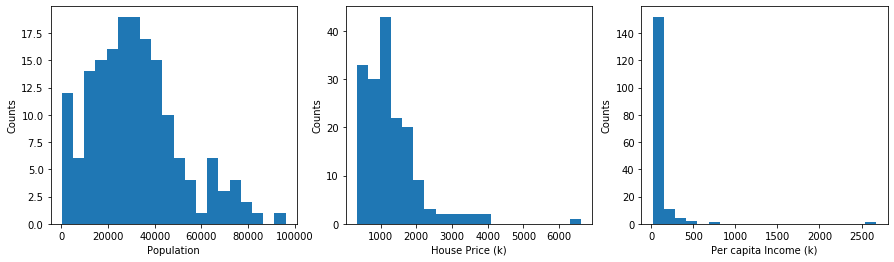

In [11]:
plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.hist(BayAreaZip['Population'],bins=20)
plt.xlabel('Population')
plt.ylabel('Counts')

plt.subplot(1,3,2)
plt.xlabel('House Price (k)')
plt.ylabel('Counts')

plt.hist(BayAreaZip['House Price 2020 (k)'],bins=20)
plt.subplot(1,3,3)
plt.hist(BayAreaZip['AGI per capita (k)'],bins=20)
plt.xlabel('Per capita Income (k)')
plt.ylabel('Counts')

plt.show()


#### Redo house price and per capita income with the outlier (zip code 94027 -Atherton) excluded for better view.

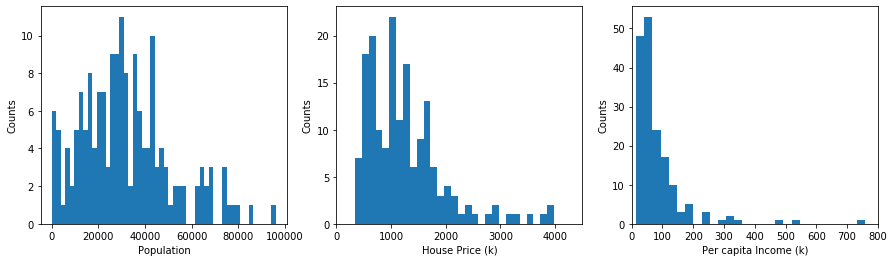

In [12]:
plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.hist(BayAreaZip['Population'],bins=50)
plt.xlabel('Population')
plt.ylabel('Counts')

plt.subplot(1,3,2)
plt.xlabel('House Price (k)')
plt.ylabel('Counts')
plt.xlim(0, 4500)

plt.hist(BayAreaZip['House Price 2020 (k)'],bins=50)
plt.subplot(1,3,3)
plt.hist(BayAreaZip['AGI per capita (k)'],bins=100)
plt.xlabel('Per capita Income (k)')
plt.ylabel('Counts')
plt.xlim(0, 800)

plt.show()

#### Next to check correlation between the three parameters. Correlation between housing price and per capita income is lower than expected. Check scattered data. 

                      Population  House Price 2020 (k)  AGI per capita (k)
Population              1.000000             -0.228067           -0.249686
House Price 2020 (k)   -0.228067              1.000000            0.363845
AGI per capita (k)     -0.249686              0.363845            1.000000


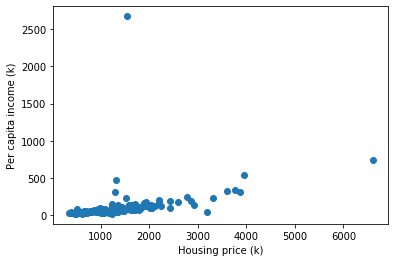

In [13]:
X = BayAreaZip[['Population', 'House Price 2020 (k)', 'AGI per capita (k)']]
X = BayAreaZip[['Population', 'House Price 2020 (k)', 'AGI per capita (k)']]
print(X.corr())

df = BayAreaZip[['Population', 'House Price 2020 (k)', 'AGI per capita (k)']].astype(float)
plt.scatter(df['House Price 2020 (k)'], df['AGI per capita (k)'])
plt.xlabel('Housing price (k)')
plt.ylabel('Per capita income (k)')
plt.show()

#### It turns out there is an outlier wither per capita income >$2.5M. Remove this zip code and redo the plot.

                      Population  House Price 2020 (k)  AGI per capita (k)
Population              1.000000             -0.226810           -0.330512
House Price 2020 (k)   -0.226810              1.000000            0.820047
AGI per capita (k)     -0.330512              0.820047            1.000000


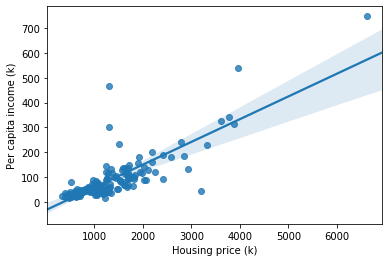

In [14]:
import seaborn as sns

BayAreaZip[['Population', 'House Price 2020 (k)', 'AGI per capita (k)']] = BayAreaZip[['Population', 'House Price 2020 (k)', 'AGI per capita (k)']].astype(float)
BayAreaZip.drop(BayAreaZip[BayAreaZip['AGI per capita (k)']>2500].index, inplace=True)  #drop a row per a condition 

X = BayAreaZip[['Population', 'House Price 2020 (k)', 'AGI per capita (k)']]
X = BayAreaZip[['Population', 'House Price 2020 (k)', 'AGI per capita (k)']]
print(X.corr())

sns.regplot(BayAreaZip['House Price 2020 (k)'], BayAreaZip['AGI per capita (k)'])
plt.xlabel('Housing price (k)')
plt.ylabel('Per capita income (k)')
plt.show()


#### Dispaly  the bay area with each zip code as a marker.

#### Housing price has strong correlation with per capita income as expected. Will use per capita income instead of housing price, along with population for zip code clustering. 
Try KMeans with with different number of cluasters and pick k = 2 based on elbow plot. 

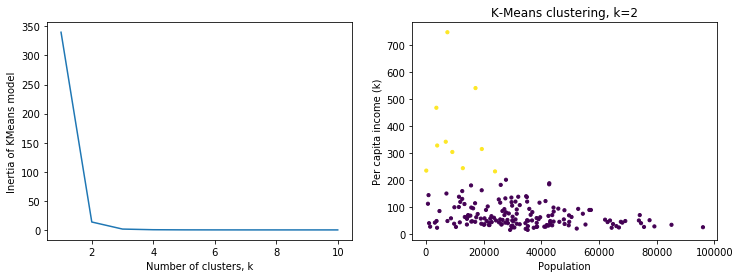

In [64]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

X = BayAreaZip[['Population', 'AGI per capita (k)']]
X = StandardScaler().fit_transform(X)
labelList = []

"""
Code below tried 4 different runs of the KMeans model, with very much the same results.
""" 
""" 
for k in np.arange(4):
    zipKM = KMeans(n_clusters=4, n_init=12)
    zipKM.fit(X)
    labelList.append(zipKM.labels_)

plt.figure(figsize=(15,4))
plt.subplot(1,4,1)
plt.scatter(X['Population'], X['AGI per capita (k)'], s=10, c=labelList[0])
plt.subplot(1,4,2)
plt.scatter(X['Population'], X['AGI per capita (k)'], s=10, c=labelList[1])
plt.subplot(1,4,3)
plt.scatter(X['Population'], X['AGI per capita (k)'], s=10, c=labelList[2])
plt.subplot(1,4,4)
plt.scatter(X['Population'], X['AGI per capita (k)'], s=10, c=labelList[3])
plt.show()
"""

kmeansInertiaList = []
kList = []
for k in range(1, 11):
    zipKM = KMeans(n_clusters=k, n_init=12)
    zipKM.fit(X)
    kList.append(k)
    kmeansInertia = zipKM.inertia_/np.square(k)
    kmeansInertiaList.append(kmeansInertia/k**2)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)    
plt.plot(kList, kmeansInertiaList,label='Inertia')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia of KMeans model')
 
#Rerun with k=4
zipKM = KMeans(n_clusters=2, n_init=12)
zipKM.fit(X)

plt.subplot(1,2,2)
X = BayAreaZip[['Population', 'AGI per capita (k)']]
plt.scatter(X['Population'], X['AGI per capita (k)'], s=10, c=zipKM.labels_)
plt.xlabel('Population')
plt.ylabel('Per capita income (k)')
plt.title('K-Means clustering, k=2')
plt.show()



The clustering clearly lacks resolution for both parameters.

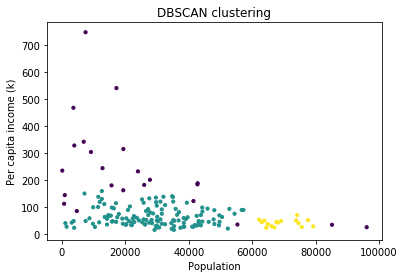

In [46]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

X = BayAreaZip[['Population', 'AGI per capita (k)']].astype(float)
X_feature = StandardScaler().fit_transform(X)
cl = DBSCAN(eps=0.3, min_samples=5)
cl.fit(X_feature)
unique, counts = np.unique(cl.labels_, return_counts=True)
unique, counts

labelList = np.array(cl.labels_) 
plt.scatter(X['Population'], X['AGI per capita (k)'], s=10, c=labelList)
plt.xlabel('Population')
plt.ylabel('Per capita income (k)')
plt.title('DBSCAN clustering')
plt.show()


It separates those higher income zip code better than KMeans, but still not ideal. The fundamental reason is that the population and income data are distributed more continuously rather than forming clear clusters. Next, I'll just manually assign population and income into 4 bins each. 

In [76]:
#Assign Population, income, and housing price Bins per the following ranges
populationCutEdges = [0, 20000, 40000, 60000, 100000] 
incomeCutEdges = [0, 80, 150, 500, 3000] 
housePriceCutEdges =  [0, 1000, 2000, 4000, 8000] 
cutEdgeDict = {'Population Bins': populationCutEdges, 'Income Bins (k)': incomeCutEdges, 'Housing Price Bin (ks': housePriceCutEdges}
cutEdgeDF = pd.DataFrame(cutEdgeDict)
cutEdgeDF.reset_index(drop=True, inplace=True)
cutEdgeDF

,Population Bins,Income Bins (k),Housing Price Bin (ks
0,0,0,0
1,20000,80,1000
2,40000,150,2000
3,60000,500,4000
4,100000,3000,8000


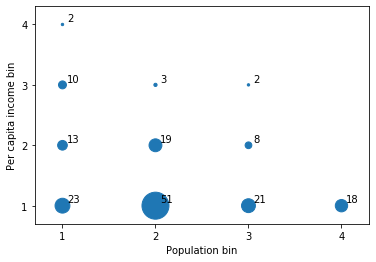

In [77]:
#Assign Population, income, and housing price Bins per the following ranges
BayAreaZip['Population Bin'] = pd.cut(BayAreaZip['Population'], populationCutEdges, labels=[1,2,3,4])
BayAreaZip['AGI per capita Bin'] = pd.cut(BayAreaZip['AGI per capita (k)'], incomeCutEdges, labels=[1,2,3,4])
BayAreaZip['House Price Bin'] = pd.cut(BayAreaZip['House Price 2020 (k)'], housePriceCutEdges, labels=[1,2,3,4])

#Create new column for combined population and income bins
BayAreaZip['Pop_AGIperCapita Bin'] = BayAreaZip['Population Bin'].astype(str) + '_' + BayAreaZip['AGI per capita Bin'].astype(str)
X = BayAreaZip[['Population Bin', 'AGI per capita Bin', 'House Price Bin']].astype(int)
#X = BayAreaZip[['Population', 'AGI per capita (k)','House Price 2020 (k)']].astype(float)
binCount = BayAreaZip[['Population Bin', 'AGI per capita Bin']].groupby(['Population Bin', 'AGI per capita Bin']).size()  #4x4 16 bins counts per bin

popBin = 4
incomeBin = 4
pop_X = []
inc_Y =[]
count_Z =[]
for pop in range(1, 5):  #generate 
    for inc in range(1, 5):
        pop_X.append(pop)   #population bin number, 1-4 for low to high population
        inc_Y.append(inc)   #income bin number, 1-4 for low to high population
        if (pop, inc) in binCount.index:
            count_Z.append(binCount.loc[(pop,inc)])
        else: 
            count_Z.append(0)
                
#Plot distribution of population and income by bins. 1 is lowest, 4 is highest. number and size of the symbol denote the number of zip codes in that bin.                
plt.figure()
plt.scatter(pop_X, inc_Y, s=2*np.power(np.array(count_Z),1.5))

for pop in range(1, 5):
    for inc in range(1, 5):
        if count_Z[(pop-1)*4+inc-1] > 0:
            plt.text(x=pop+.05, y=inc+.05, s=count_Z[(pop-1)*4+inc-1])
plt.xlim(0.7, 4.3)
plt.ylim(0.7, 4.3)
plt.xticks([1, 2, 3, 4])
plt.yticks([1, 2, 3, 4])
plt.xlabel('Population bin')
plt.ylabel('Per capita income bin')
plt.show()



#### The plot above shows the distribution of population and income by bins. 1 is lowest, 4 is highest. The number and size of the symbols denote the number of zip codes in that bin. 

#### The 4 dots corresponding to population_income bin of 2_2, 2_3, 3_2, and 3_3 are of more interest than the rest of the area, because they have combinations of relatively higher income and higher population, which could be better areas to consider opending a business. These zip codes are extracted using the code below and then highlighted  in the map below. 

In [84]:
highIncomeHighPopBins = ['2_2', '2_3', '3_2', '3_3']
Zip_highIncome_HighPop = BayAreaZip['Pop_AGIperCapita Bin'].isin(highIncomeHighPopBins)
BayAreaZip_interest = BayAreaZip[Zip_highIncome_HighPop]  #of interest (high income, high population)
BayAreaZip_NonInterest = BayAreaZip[~Zip_highIncome_HighPop]  #not of interest (the rest)


The two maps below first display all zip codes of the bay area, then highlight those of business interest from the above selection.

In [42]:
import folium
import matplotlib.pyplot as plt

bayAreaLat = BayAreaZip['Latitude'].mean()   #bay area lat, lng
bayAreaLng = BayAreaZip['Longitude'].mean()
mapBayArea = folium.Map(location=[bayAreaLat, bayAreaLng], zoom_start=9)
 
for row in BayAreaZip[['ZIP', 'Latitude','Longitude','City','Metro']].iterrows():
    z = row[1].ZIP
    lat = row[1].Latitude
    lng = row[1].Longitude
    city = row[1].City
    metro= row[1].Metro

    label = '{}, {}'.format(city, metro)
    label = folium.Popup('Zip code: %s' %(z), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(mapBayArea)  

mapBayArea
 

In [85]:
import folium
import matplotlib.pyplot as plt

bayAreaLat = BayAreaZip['Latitude'].mean()   #bay area lat, lng
bayAreaLng = BayAreaZip['Longitude'].mean()
mapBayArea = folium.Map(location=[bayAreaLat, bayAreaLng], zoom_start=9)
 
for row in BayAreaZip_interest[['ZIP', 'Latitude','Longitude','City','Metro']].iterrows():
    z = row[1].ZIP
    lat = row[1].Latitude
    lng = row[1].Longitude
    city = row[1].City
    metro= row[1].Metro

    label = '{}, {}'.format(city, metro)
    label = folium.Popup('Zip code: %s' %(z), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(mapBayArea)  

for row in BayAreaZip_NonInterest[['ZIP', 'Latitude','Longitude','City','Metro']].iterrows():
    z = row[1].ZIP
    lat = row[1].Latitude
    lng = row[1].Longitude
    city = row[1].City
    metro= row[1].Metro

    label = '{}, {}'.format(city, metro)
    label = folium.Popup('Zip code: %s' %(z), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='gray',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(mapBayArea)  
    
mapBayArea

#### With this binning (labeling) information we can display the zip codes per population, housing price, and per capita income bins as shown below.

#### Display all area zip codes color coded by housing price, with clickable markers labeling each zip code and housing price.

In [38]:
# create map
import matplotlib.cm as cm
import matplotlib.colors as colors

#BayAreaZip['House Price Bin'] = pd.cut(BayAreaZip['House Price 2020 (k)'], [0, 1000, 2000, 4000, 8000], labels=[1,2,3,4])
#BayAreaZip['House Price Bin'] = pd.qcut(BayAreaZip['House Price 2020 (k)'], [0, 0.25, 0.5, 0.75, 1], labels=[1,2,3,4])

map_clusters = folium.Map(location=[bayAreaLat, bayAreaLng], zoom_start=9)

# add markers to the map
markers_colors = []
clusters = []

# set color scheme for the clusters
kclusters = 4
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
    
for row in BayAreaZip[['ZIP','Latitude','Longitude','City','Metro', 'House Price Bin', 'House Price 2020 (k)']].iterrows():
    z = row[1].ZIP
    lat = row[1].Latitude
    lng = row[1].Longitude
    city = row[1].City
    metro= row[1].Metro
    cluster = row[1]['House Price Bin']
    housePrice = row[1]['House Price 2020 (k)']
    
    label = folium.Popup('Zip code: %s Median Housing Price: \$%.0f k' %(z, housePrice), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)

#plt.figure(figsize=(12,12))
map_clusters

#### Display all area zip codes color coded by per capita income with clickable markers.

In [39]:
# create map
import matplotlib.cm as cm
import matplotlib.colors as colors

map_clusters = folium.Map(location=[bayAreaLat, bayAreaLng], zoom_start=9)
kclusters = 4

#BayAreaZip['AGI per capita Bin'] = pd.qcut(BayAreaZip['AGI per capita (k)'], [0, 0.25, 0.5, 0.75, 1], labels=[1,2,3,4])
#BayAreaZip['AGI per capita Bin'] = pd.cut(BayAreaZip['AGI per capita (k)'], [0, 80, 150, 500, 3000], labels=[1,2,3,4])

# add markers to the map
markers_colors = []
clusters = []

# set color scheme for the clusters
kclusters = 4
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
    
for row in BayAreaZip[['ZIP', 'Latitude','Longitude','City','Metro', 'AGI per capita (k)', 'AGI per capita Bin']].iterrows():
    z = row[1].ZIP
    lat = row[1].Latitude  #row is a tuple, 1st element is row number, second element is a series for the 5 columns
    lng = row[1].Longitude
    city = row[1].City
    metro= row[1].Metro
    cluster = row[1]['AGI per capita Bin']
    income = row[1]['AGI per capita (k)']
    
    label = folium.Popup('Zip code: %s Per capita income: \$%.1f k' %(z, income), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters


#### Display all area zip codes color coded by population with clickable markers.

In [40]:
# create map
import matplotlib.cm as cm
import matplotlib.colors as colors

map_clusters = folium.Map(location=[bayAreaLat, bayAreaLng], zoom_start=9)
kclusters = 4

#BayAreaZip['Population Bin'] = pd.cut(BayAreaZip['Population'], [0,20000,40000, 60000, 100000], labels=[1,2,3,4])
#BayAreaZip['Population Bin'] = pd.qcut(BayAreaZip['Population'], [0, 0.25, 0.5, 0.75, 1], labels=[1,2,3,4])

# add markers to the map
markers_colors = []
clusters = []

# set color scheme for the clusters
kclusters = 4
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
    
for row in BayAreaZip[['ZIP','Latitude','Longitude','City','Metro', 'Population Bin', 'Population']].iterrows():
    z = row[1].ZIP
    lat = row[1].Latitude
    lng = row[1].Longitude
    city = row[1].City
    metro= row[1].Metro
    cluster = row[1]['Population Bin']
    pop = row[1]['Population']
    
    label = folium.Popup('Zip Code: %s Population: %d' %(z, pop), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters


#### Next to use Foursquare API to get venues from the zip codes of interest. 

#### Function to get high level category. 

In [232]:
# Function that extracts the HIGH LEVEL category of the venue, instead of the specific category name.
# For example, a Chinese restaurant's HIGH LEVEL category name would be "food"
# This is helpful for high level picture of distritbuion of a certain type of venues like food rather 
# than the specific categories like Chinese restaurant.

def get_HLcategory_type(row):
    if not bool(row):  #if this row (a dict) is empty
        category = None
    else:
        try:
            categories_list = row['venue']['categories']  
            #categories_list = row['categories']
        except:
            categories_list = None
        if len(categories_list) == 0:
            return None
        else:
            icon = categories_list[0]['icon']['prefix']
            icon = icon.split('/')
            idx = icon.index('categories_v2')
            category = icon[idx+1] 
    return category

#dict1 = {}
#a = get_HLcategory_type(dict1)

#### A function to return venues for all zip codes in an area, in this case, the selected zip code of interest.

In [236]:
def getNearbyVenues(DF, radius=500, LIMIT=10):
    """
    Using Foursquare API call to get all venues of interest for a list of zip codes contained in a dataframe DF.
    DF: dataframe with at least these columns: ZIP, Latitude, Longitude
    radius: radius around the Latitude and Longitude to search
    LIMIT: maximum number of venues to return from the search
    """
    
    import requests

    #Foursquare credentials
    CLIENT_ID = 'IWTXQ1HY3TIXMASV3GODHCMKA4EEOVINEXUSDYV5EUPC5RVX' # your Foursquare ID
    CLIENT_SECRET = 'C12JHBMT0ZTL0PLAI304G4HVGPZ2KIGU0OV1WMUAZVPUYMLO' # your Foursquare Secret
    VERSION = '20200101' # Foursquare API version
    
    venues_list=[]
    for row in DF[['ZIP', 'Latitude', 'Longitude']].iterrows():
        ZIP = row[1].ZIP
        lat = row[1].Latitude
        lng = row[1].Longitude
        print("Zip code: ", ZIP)
 
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
       
        if not results: #if results is empty
            print('No venues found ...')
            venues_list.append([(
                ZIP, 
                lat, 
                lng, 
                None, 
                None, 
                None,   
                None)])
        else:
            for v in results:
                category = get_HLcategory_type(v)    
                print(v['venue']['name'], ':', category)   #print the vanue name and high level category

                venues_list.append([(
                    ZIP, 
                    lat, 
                    lng, 
                    v['venue']['name'], 
                    v['venue']['location']['lat'], 
                    v['venue']['location']['lng'],  
                    category)])  #High level category name
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['ZIP', 
                  'ZIP Latitude', 
                  'ZIP Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Get venues for all zip codes of interest within 1000 meters of center of the zip code, up to 200 eac.

In [323]:
#Call the function to get all venues for the zip codes of interest within a radius of 500 meters of the 
#center of the zip code, up to 100
selectBAVenues = getNearbyVenues(BayAreaZip_interest, radius=1000, LIMIT=200)

#Get total counts of venues returned for each zip code
selectBAVenues = selectBAVenues[['ZIP', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']]#selectBAVenues = selectBAVenues[['ZIP', 'Venue Category']]
selectBAVenues = selectBAVenues[['ZIP', 'Venue Category']]
selectBAVenues.dropna(inplace=True)  #drop those zip codes with 0 venues returned
totalVenuesGroup = selectBAVenues.groupby('ZIP').count()

#Get counts of venues for each HIGH LEVEL venue category for each zip code
by_category_Count = selectBAVenues.groupby('ZIP')['Venue Category'].value_counts().unstack(fill_value=0) #count for each category as one column

#Combine into one dataframe
totalVenuesGroup.reset_index(inplace=True)
by_category_Count.reset_index(inplace=True)
by_category_Count.reset_index(drop=True, inplace=True)
totalVenuesGroup = totalVenuesGroup.merge(by_category_Count, left_on='ZIP', right_on='ZIP', how='inner')
totalVenuesGroup.rename(columns={'Venue Category': 'Total Venues'}, inplace=True)
totalVenuesGroup


Zip code:  94941
Joe's Taco Lounge : food
Sol Food Puerto Rican Cuisine : food
Whole Foods Market : shops
Super Duper Burger : food
Samurai Japanese Restaurant : food
Mill Valley Lumber Yard : shops
Marin Theatre Company : arts_entertainment
Flourcraft Bakery : food
TamalPie : food
Red Dragon Yoga : shops
Kitchen Sunnyside : food
Grilly's Mill Valley : food
Prabh Indian Kitchen : food
Boyle Park : parks_outdoors
Watershed Restaurant : food
7-Eleven : shops
Mama's Royal Cafe : food
Boo Koo : food
2AM Club : nightlife
Tenderfoot Trail : parks_outdoors
Mill Valley Swirl : food
Mill Valley Coffee Shop : food
Jiffy Lube : shops
Wells Fargo : shops
Jolly King Liquors : shops
Sycamore Park : parks_outdoors
Safeway : shops
Pilates ProWorks® : building
Beads of Marin : shops
The Parlor : shops
Silver Screen Video : shops
Toyhouse : shops
West Coast Wine • Cheese MV : food
Zip code:  94611
Piedmont Park : parks_outdoors
Piedmont Community Hall : arts_entertainment
Mulberry's Market : shops
Montc

,ZIP,Total Venues,arts_entertainment,building,education,food,nightlife,parks_outdoors,shops,travel
0,94403,100,2,0,1,38,4,3,52,0
1,94506,29,2,2,1,12,1,2,9,0
2,94526,40,1,5,0,17,0,0,14,3
3,94539,6,0,0,0,0,0,3,3,0
4,94549,75,1,1,1,47,1,0,24,0
5,94566,74,2,0,0,49,2,1,18,2
6,94583,57,1,4,1,27,1,3,18,2
7,94596,100,2,2,0,71,8,1,15,1
8,94611,15,4,0,0,1,0,8,2,0
9,94941,33,1,1,0,15,1,3,12,0


Further process the returned venues, sort by total venues and a given type of venue, say, food:

In [337]:
totalAndFoodVenuesGroup = totalVenuesGroup[['ZIP', 'Total Venues', 'food']]
totalAndFoodVenuesGroup = totalAndFoodVenuesGroup.sort_values(['Total Venues', 'food'], ascending = (False, False))
totalAndFoodVenuesGroup ['Food Venue %'] = totalAndFoodVenuesGroup['food'] / totalAndFoodVenuesGroup['Total Venues'] * 100.0
pd.options.display.float_format = '{:.1f}'.format
totalAndFoodVenuesGroup.reset_index(drop=True, inplace=True)
totalAndFoodVenuesGroup

,ZIP,Total Venues,food,Food Venue %
0,94596,100,71,71.0
1,94403,100,38,38.0
2,94549,75,47,62.7
3,94566,74,49,66.2
4,94583,57,27,47.4
5,94526,40,17,42.5
6,94941,33,15,45.5
7,94506,29,12,41.4
8,94611,15,1,6.7
9,94539,6,0,0.0


Now we have the top 10 zip codes in the bay areas with most venues near the center of the zip code, with number of venues in food category ranked high to low. For example, the top 2 zip codes, 94596 and 94403, both have 100 venues, but 94596 have nearly double food venues compared to 94403. This suggest 94403 zip code may have less competition than 94596, among other factors to be considered. Since the last 2 zip codes have much fewer venues than the rest, they are dropped for the next step.

Finally, we have the top 8 zip codes as candidates for someone who is interested in opening a food related business in the bay area. 

In [339]:
totalAndFoodVenuesGroup = totalAndFoodVenuesGroup[:8]  #top 8 rows

#add longitude and latitude back to the final dataframe with 8 candidate zip codes:
BAZip = BayAreaZip[['ZIP', 'City', 'Latitude', 'Longitude']]
totalAndFoodVenuesGroup = totalAndFoodVenuesGroup.merge(BAZip, left_on='ZIP', right_on='ZIP', how='inner')
totalAndFoodVenuesGroup

,ZIP,Total Venues,food,Food Venue %,City,Latitude,Longitude
0,94596,100,71,71.0,Walnut Creek,37.9,-122.1
1,94403,100,38,38.0,San Mateo,37.5,-122.3
2,94549,75,47,62.7,Lafayette,37.9,-122.1
3,94566,74,49,66.2,Pleasanton,37.7,-121.9
4,94583,57,27,47.4,San Ramon,37.8,-122.0
5,94526,40,17,42.5,Danville,37.8,-122.0
6,94941,33,15,45.5,Mill Valley,37.9,-122.5
7,94506,29,12,41.4,Danville,37.8,-121.9


The 8 zip codes are displayed on the map below with zip codes, total venues (within 1000 meters of center of the zip code), and number of food venues displayed on the clickable markers. These are the candidate zip codes for someone interested in opending a food related business in the bay area. Obviously this can be extended to other categories.

In [336]:
import folium
import matplotlib.pyplot as plt

bayAreaLat = BayAreaZip['Latitude'].mean()   #bay area lat, lng
bayAreaLng = BayAreaZip['Longitude'].mean()
mapBayArea = folium.Map(location=[bayAreaLat, bayAreaLng], zoom_start=9)

for row in totalAndFoodVenuesGroup[['ZIP', 'Latitude','Longitude','Total Venues','food']].iterrows():
    z = row[1].ZIP
    lat = row[1].Latitude
    lng = row[1].Longitude
    totVenue = row[1]['Total Venues']
    food = row[1].food

    label = '{}, {}'.format(city, metro)
    label = folium.Popup('Zip code: %s \n total Venues: %d\n Food venues: %d' %(z, totVenue, food), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(mapBayArea)  
    
mapBayArea